# Pipeline Testing

In [187]:
#
import os
import numpy as np
import pandas as pd
from pandas import Timestamp
import seaborn as sns
import matplotlib.pyplot as plt
#
from talib import RSI, BBANDS, MACD, ATR
#
from zipline.api import order_target_percent, record, symbol, set_benchmark, get_open_orders
import zipline
import datetime
import pytz
from zipline.data.bundles import load
from trading_calendars import get_calendar
import pyfolio as pf
#
%load_ext zipline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


## Check Symbols of Bundle

In [178]:
now = Timestamp.utcnow()
bundle = load('NFTU', os.environ, now)
symbols = set(str(asset.symbol) 
              for asset in bundle.asset_finder.retrieve_all(
                           bundle.asset_finder.equities_sids))

print(symbols)

{'AVAX', 'SOL', 'ADA', 'MATIC', 'TFUEL', 'AMI', 'MANA', 'FLOW'}


## Simple Strategy

In [179]:
selected_coin = 'ADA'
shortest_period = 7
longest_period = 14
holding_period = 2

def initialize(context):
    context.i = 0
    context.holding_days = 0
    context.bought = False
    set_benchmark(symbol(selected_coin))
    context.asset = symbol(selected_coin)

def handle_data(context, data):
    # skip days for moving average
    context.i += 1
    if context.i < longest_period:
        return
    if context.bought:
        context.holding_days += 1
        
    # trading algorithm
    short_ma = data.history(context.asset, 'close', bar_count=shortest_period, frequency='1d').mean()
    long_ma = data.history(context.asset, 'close', bar_count=longest_period, frequency='1d').mean()

    open_orders = get_open_orders()
    
    # buy signal
    if context.asset not in open_orders:
        if short_ma > long_ma and context.holding_days == 0 and not context.bought:
            order_target_percent(context.asset, 1.0)
            context.bought = True
        
    # sell signal
    if (short_ma < long_ma or context.holding_days == holding_period) and context.bought:
        order_target_percent(context.asset, 0.0)
        context.holding_days = 0
        context.bought = False

    # record price
    record(close=data.current(symbol(selected_coin), 'close'),
          short_ma=short_ma,
          long_ma=long_ma)

In [181]:
# date range MUST BE pd.Timestamp
start_date = pd.Timestamp('2017-11-09', tz='utc')
end_date = pd.Timestamp('2022-04-17', tz='utc')

# performance of algorithm once run
perf = zipline.run_algorithm(start=start_date,
                            end=end_date,
                            trading_calendar=get_calendar('24/7'),
                            initialize=initialize,
                            capital_base=40000,
                            handle_data=handle_data,
                            bundle='NFTU',
                            data_frequency='daily')
perf.head()
perf.tail()

C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


,period_open,period_close,long_value,short_value,ending_exposure,starting_value,positions,starting_exposure,transactions,capital_used,...,sortino,period_label,max_leverage,trading_days,benchmark_period_return,benchmark_volatility,algo_volatility,close,short_ma,long_ma
2022-04-13 23:59:00+00:00,2022-04-13 00:00:00+00:00,2022-04-13 23:59:00+00:00,0.0,0.0,0.0,0.0,[],0.0,[],0.0,...,-0.451219,2022-04,2.910809,1617,38.00,1.237874,1.026563,0.975,1.008571,1.082071
2022-04-14 23:59:00+00:00,2022-04-14 00:00:00+00:00,2022-04-14 23:59:00+00:00,0.0,0.0,0.0,0.0,[],0.0,[],0.0,...,-0.451079,2022-04,2.910809,1618,36.24,1.237649,1.026246,0.931,0.985429,1.066929
2022-04-15 23:59:00+00:00,2022-04-15 00:00:00+00:00,2022-04-15 23:59:00+00:00,0.0,0.0,0.0,0.0,[],0.0,[],0.0,...,-0.450940,2022-04,2.910809,1619,37.20,1.237294,1.025929,0.955,0.975143,1.052000
2022-04-16 23:59:00+00:00,2022-04-16 00:00:00+00:00,2022-04-16 23:59:00+00:00,0.0,0.0,0.0,0.0,[],0.0,[],0.0,...,-0.450801,2022-04,2.910809,1620,37.08,1.236916,1.025612,0.952,0.961857,1.037286
2022-04-17 23:59:00+00:00,2022-04-17 00:00:00+00:00,2022-04-17 23:59:00+00:00,0.0,0.0,0.0,0.0,[],0.0,[],0.0,...,-0.450662,2022-04,2.910809,1621,35.64,1.236648,1.025296,0.916,0.943429,1.018000


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,99.74,2018-01-03,2021-03-15,NaT,NaN
1,33.46,2017-11-28,2017-12-10,2017-12-16,14
2,23.30,2017-12-19,2017-12-24,2017-12-29,9
3,2.64,2017-11-22,2017-11-24,2017-11-25,3
4,0.26,2017-12-17,2017-12-18,2017-12-19,2


C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 73.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexes\base.py:5278: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,-0.08%,-27.51%,178.52%


C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\pandas\core\indexes\base.py:5278: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Top 10 long positions of all time,max
sid,
ADA,291.08%


Top 10 short positions of all time,max
sid,
ADA,-148.57%


Top 10 positions of all time,max
sid,
ADA,291.08%


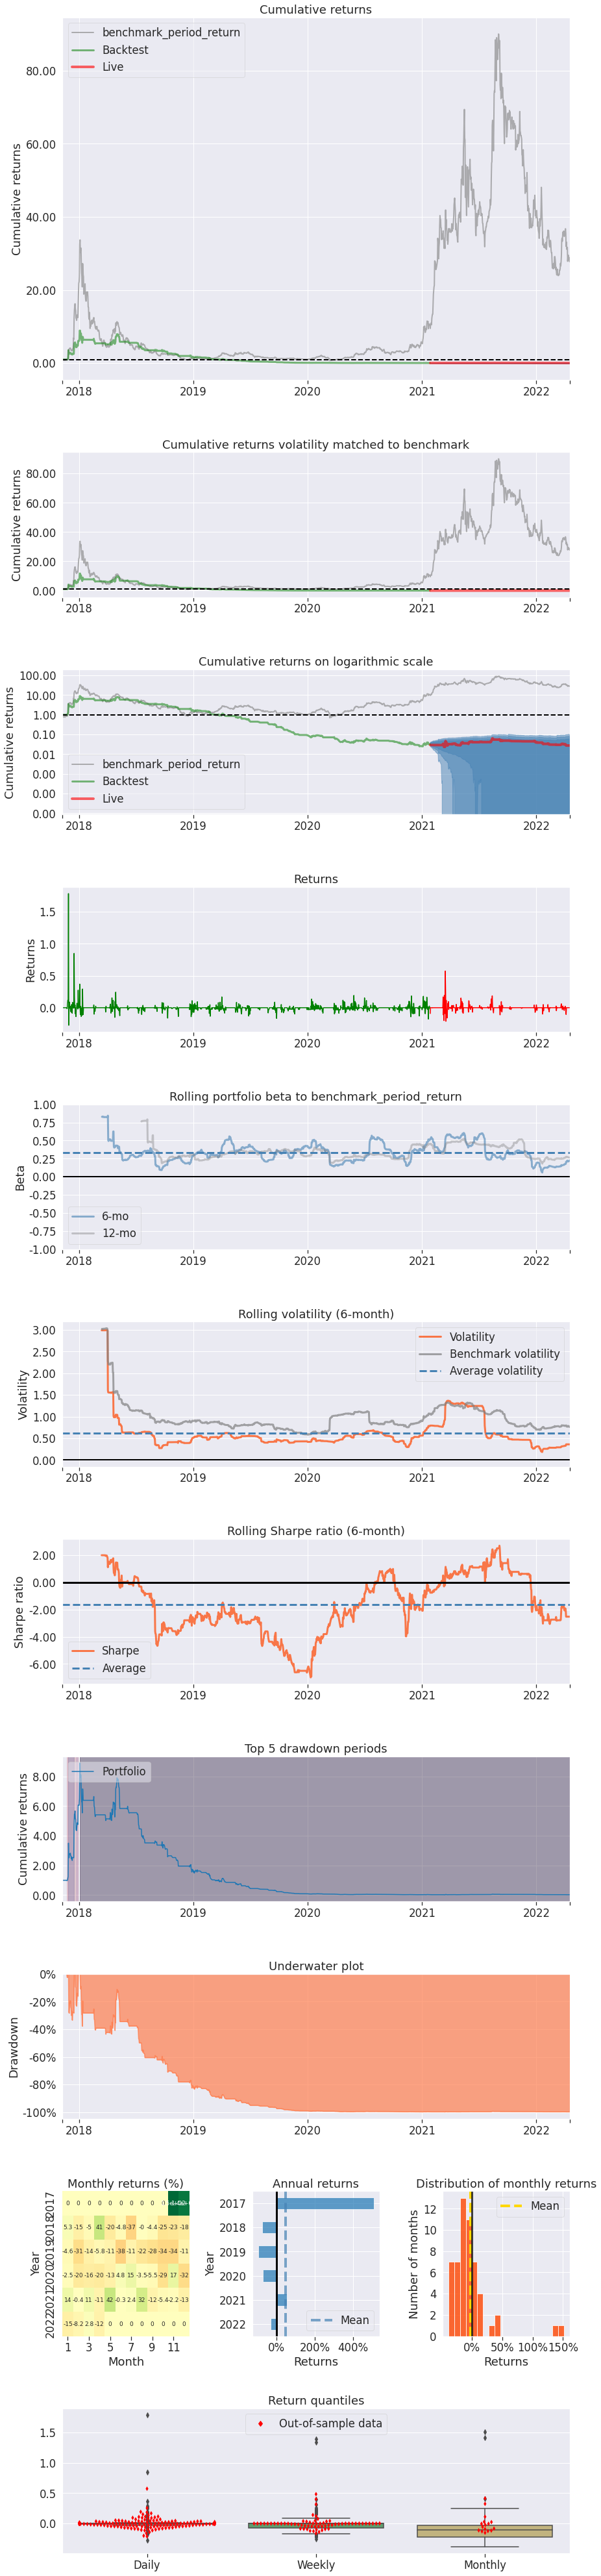

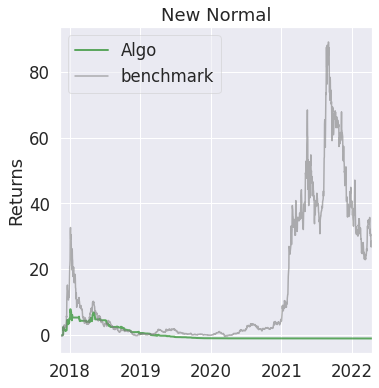

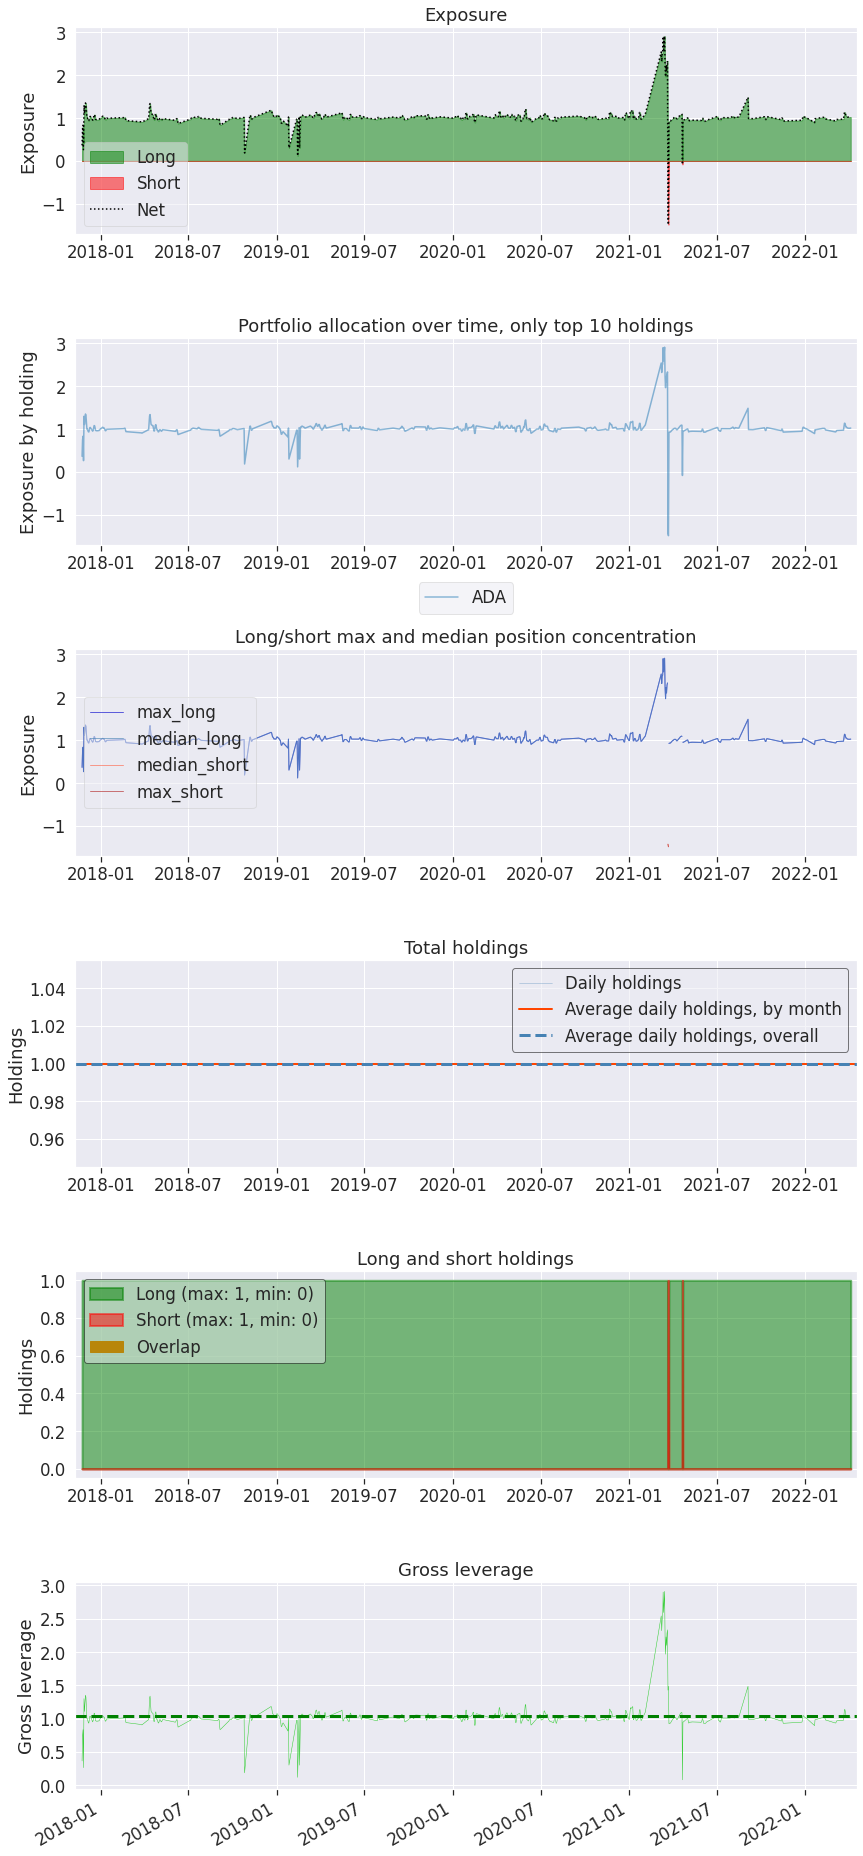

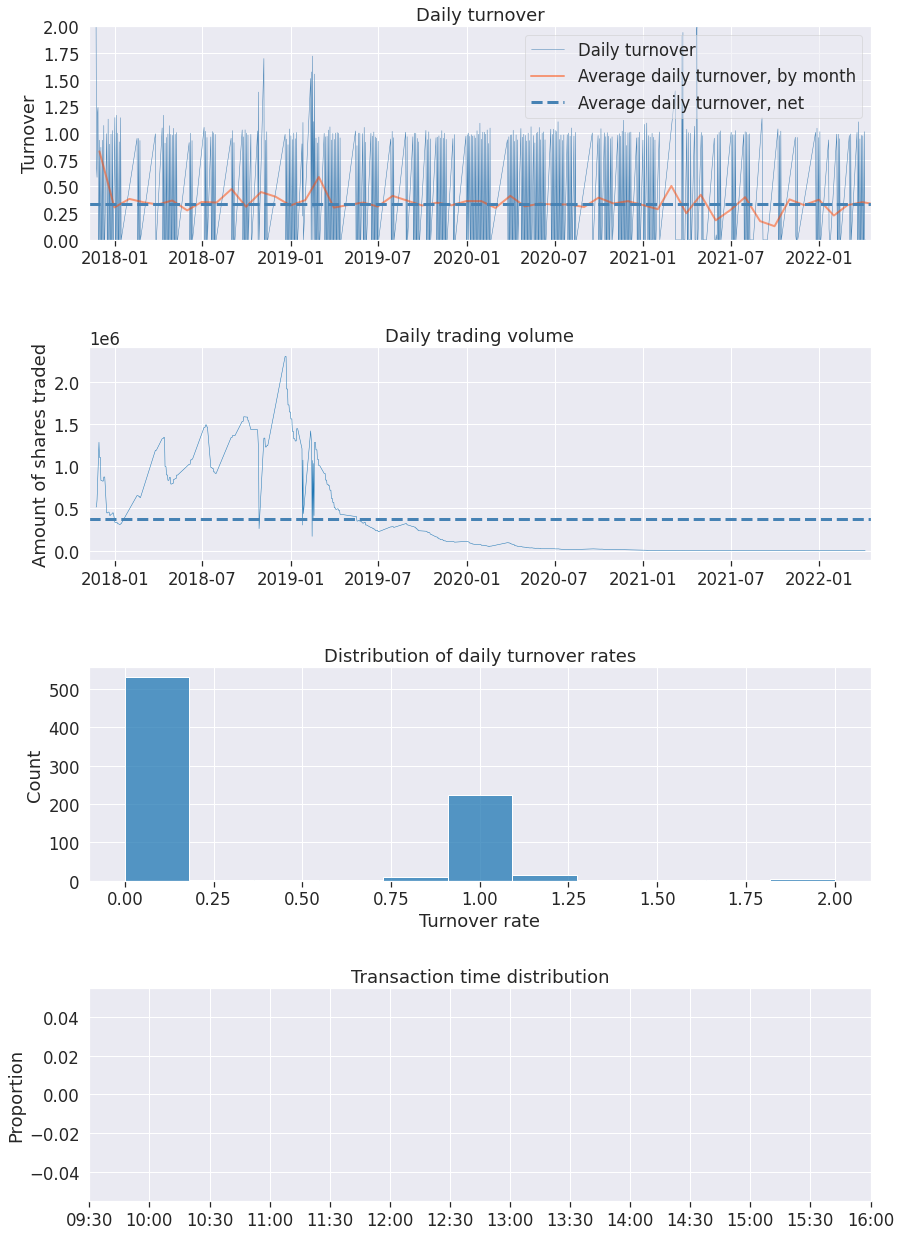

In [182]:
# Extract algo returns and benchmark returns
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf['benchmark_period_return']

# Convert benchmark returns to daily returns
#daily_returns = (1 + benchmark_period_return) / (1 + benchmark_period_return.shift()) - 1
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1

# Create tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns, live_start_date='2021-01-27')

## Simulation of Sentiment Data

One of the NFT signals we will be looking at first is sentiment data from messages about NFTs and/or the specific chains of the coins of our universe. We can start simply by assuming that text data will be assigned a 0 if it has negative sentiment, and a 1 if it has positive sentiment. Then, for trading purposes we will simulate the overall sentiment of each day with a 0 or 1.

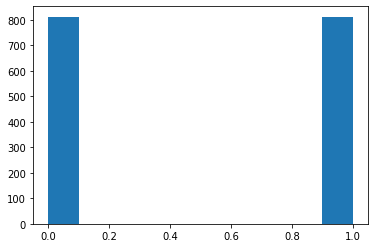

In [183]:
simulated_sentiment_arr = np.random.randint(0, 2, (end_date - start_date).days+1)
_ = plt.hist(simulated_sentiment_arr)

In [185]:
selected_coin = 'ADA'
holding_period = 2

def initialize(context):
    context.i = 0
    context.holding_days = 0
    context.bought = False
    set_benchmark(symbol(selected_coin))
    context.asset = symbol(selected_coin)

def handle_data(context, data):
    if context.bought:
        context.holding_days += 1
        
    # trading algorithm

    open_orders = get_open_orders()
    
    # buy signal
    if context.asset not in open_orders:
        if simulated_sentiment_arr[context.i] and context.holding_days == 0 and not context.bought:
            order_target_percent(context.asset, 1.0)
            context.bought = True
        
    # sell signal
    if (not simulated_sentiment_arr[context.i] or context.holding_days == holding_period) and context.bought:
        order_target_percent(context.asset, 0.0)
        context.holding_days = 0
        context.bought = False
        
    context.i += 1
    # record price
    record(close=data.current(symbol(selected_coin), 'close'))

In [186]:
# date range MUST BE pd.Timestamp
start_date = pd.Timestamp('2017-11-09', tz='utc')
end_date = pd.Timestamp('2022-04-11', tz='utc')

# performance of algorithm once run
perf = zipline.run_algorithm(start=start_date,
                            end=end_date,
                            trading_calendar=get_calendar('24/7'),
                            initialize=initialize,
                            capital_base=40000,
                            handle_data=handle_data,
                            bundle='NFTU',
                            data_frequency='daily')
perf.head()
perf.tail()

C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


,period_open,period_close,starting_cash,ending_cash,portfolio_value,longs_count,shorts_count,long_value,short_value,long_exposure,...,period_label,algo_volatility,benchmark_period_return,benchmark_volatility,algorithm_period_return,alpha,beta,sharpe,sortino,max_drawdown
2022-04-07 23:59:00+00:00,2022-04-07 00:00:00+00:00,2022-04-07 23:59:00+00:00,0.923367,4.197728,4.197728,0,0,0.000,0.0,0.000,...,2022-04,0.954961,42.72,1.238811,-0.999895,-0.787320,0.401252,-1.091549,-1.932018,-0.999989
2022-04-08 23:59:00+00:00,2022-04-08 00:00:00+00:00,2022-04-08 23:59:00+00:00,4.197728,1.112187,4.193187,1,0,3.081,0.0,3.081,...,2022-04,0.954665,40.08,1.238695,-0.999895,-0.786287,0.401057,-1.091387,-1.931731,-0.999989
2022-04-09 23:59:00+00:00,2022-04-09 00:00:00+00:00,2022-04-09 23:59:00+00:00,1.112187,1.112187,4.247187,1,0,3.135,0.0,3.135,...,2022-04,0.954393,40.80,1.238321,-0.999894,-0.785889,0.401072,-1.088914,-1.927401,-0.999989
2022-04-10 23:59:00+00:00,2022-04-10 00:00:00+00:00,2022-04-10 23:59:00+00:00,1.112187,4.242620,4.242620,0,0,0.000,0.0,0.000,...,2022-04,0.954098,40.80,1.237939,-0.999894,-0.785719,0.401070,-1.088752,-1.927115,-0.999989
2022-04-11 23:59:00+00:00,2022-04-11 00:00:00+00:00,2022-04-11 23:59:00+00:00,4.242620,4.242620,4.242620,0,0,0.000,0.0,0.000,...,2022-04,0.953803,35.76,1.238548,-0.999894,-0.783695,0.400375,-1.088413,-1.926518,-0.999989


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,100.00,2018-01-03,2020-11-20,NaT,NaN
1,30.63,2017-12-14,2017-12-24,2018-01-03,15
2,25.51,2017-11-30,2017-12-11,2017-12-14,11
3,21.32,2017-11-09,2017-11-26,2017-11-27,13
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2022-04-11 00:00:00+0000', tz='UTC', freq='D'))

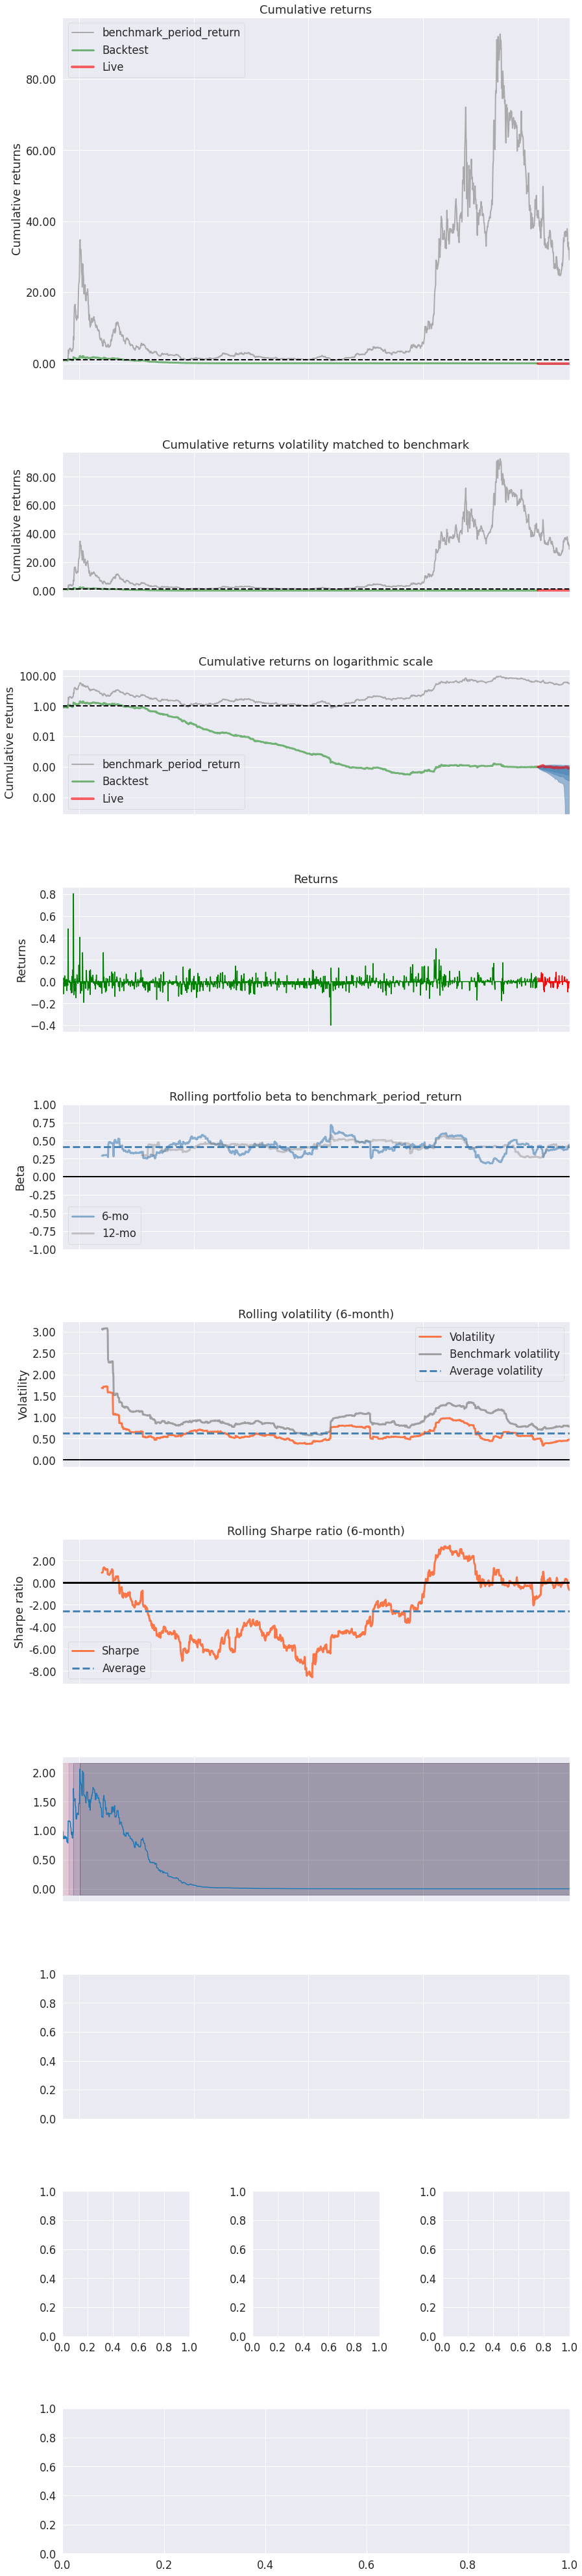

In [9]:
# Extract algo returns and benchmark returns
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf['benchmark_period_return']

# Convert benchmark returns to daily returns
#daily_returns = (1 + benchmark_period_return) / (1 + benchmark_period_return.shift()) - 1
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1

# Create tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns, live_start_date='2022-01-01')

The strategy is not good with just sentiment data alone (and no other strategy), as expected. However, these alternative and quantitative NFT data we will be using could be more effective as features in a regression model aimed to predict returns.

## OLS / Regression + Simulated Sentiment Feature Data Creation

Here the dataset for which will be the input for the predictive model.

In [148]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 2021-1-28 start
data_path = r"../data/instruments_modified"
instrument_symbols = [fn.split(".")[0] for fn in os.listdir(data_path)]

# Create hierarchical dataframe for universe of instruments?
uni_df = pd.concat([pd.read_csv(os.path.join(data_path,file)) for file in os.listdir(data_path)], keys=instrument_symbols).swaplevel()

# create multiindex
uni_df = uni_df.set_index([[tup[1] for tup in uni_df.index], pd.DatetimeIndex(uni_df['Date'])]).drop("Date", axis=1)
uni_df.index = uni_df.index.rename(("Symbol", "Date"))

In [149]:
uni_df.loc[pd.IndexSlice[:, "2021-01-28"],:]

,,Open,High,Low,Close,Volume,Market Cap
Symbol,Date,,,,,,
ADA,2021-01-28,0.313344,0.353553,0.307383,0.345811,2.184946e+09,1.053534e+10
AVAX,2021-01-28,11.171011,12.668179,10.860486,12.003784,1.096995e+08,9.095808e+08
FLOW,2021-01-28,6.936125,7.820695,6.089595,7.183794,1.363120e+07,1.641425e+08
MANA,2021-01-28,0.147498,0.164600,0.141742,0.158452,6.148773e+07,2.403431e+08
MATIC,2021-01-28,0.042006,0.044492,0.038580,0.038755,1.657363e+08,2.052327e+08
SOL,2021-01-28,3.693176,3.936221,3.612791,3.829965,8.383889e+07,9.958197e+08
TFUEL,2021-01-28,0.029300,0.031066,0.029058,0.029370,1.171442e+07,1.573075e+08


In [215]:
#uni_prices = uni_df.loc[pd.IndexSlice[:, "2021-01-28":],:]
uni_prices = uni_df.drop('Market Cap', axis=1)
uni_prices

Open      High       Low     Close        Volume
Symbol Date                                                            
ADA    2017-10-02  0.024969  0.030088  0.019969  0.025808  8.310030e+07
       2017-10-03  0.025671  0.027172  0.020575  0.020827  2.971484e+07
       2017-10-04  0.020828  0.022962  0.020828  0.021973  1.243013e+07
       2017-10-05  0.022035  0.022245  0.020839  0.021512  7.055960e+06
       2017-10-06  0.021286  0.021576  0.018071  0.018481  6.207887e+06
...                     ...       ...       ...       ...           ...
TFUEL  2022-04-13  0.164733  0.172376  0.163245  0.169795  2.146501e+07
       2022-04-14  0.169287  0.170751  0.160710  0.163625  2.503801e+07
       2022-04-15  0.163616  0.167434  0.163308  0.167315  2.003002e+07
       2022-04-16  0.167315  0.167884  0.162870  0.165885  1.721647e+07
       2022-04-17  0.165885  0.167502  0.161584  0.161584  1.854334e+07

[11613 rows x 5 columns]

### Compute RSI

In [219]:
uni_prices['rsi'] = uni_prices.groupby(level='Symbol').Close.apply(RSI)

In [220]:
uni_prices['rsi']

Symbol  Date      
ADA     2017-10-02          NaN
        2017-10-03          NaN
        2017-10-04          NaN
        2017-10-05          NaN
        2017-10-06          NaN
                        ...    
TFUEL   2022-04-13    43.725938
        2022-04-14    41.011059
        2022-04-15    43.279151
        2022-04-16    42.595503
        2022-04-17    40.522908
Name: rsi, Length: 11613, dtype: float64

### Compute Bollinger Bands

In [221]:
# Chapter 6 nb
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

uni_prices = (uni_prices.join(uni_prices
                      .groupby(level='Symbol')
                      .Close
                      .apply(compute_bb)))

uni_prices['bb_high'] = uni_prices.bb_high.sub(uni_prices.Close).div(uni_prices.bb_high).apply(np.log1p)
uni_prices['bb_low'] = uni_prices.Close.sub(uni_prices.bb_low).div(uni_prices.Close).apply(np.log1p)

In [222]:
uni_prices['bb_high']

Symbol  Date      
ADA     2017-10-02         NaN
        2017-10-03         NaN
        2017-10-04         NaN
        2017-10-05         NaN
        2017-10-06         NaN
                        ...   
TFUEL   2022-04-13    0.210931
        2022-04-14    0.235502
        2022-04-15    0.223333
        2022-04-16    0.227485
        2022-04-17    0.242599
Name: bb_high, Length: 11613, dtype: float64

In [223]:
uni_prices['bb_low']

Symbol  Date      
ADA     2017-10-02         NaN
        2017-10-03         NaN
        2017-10-04         NaN
        2017-10-05         NaN
        2017-10-06         NaN
                        ...   
TFUEL   2022-04-13    0.072361
        2022-04-14    0.054108
        2022-04-15    0.084948
        2022-04-16    0.091741
        2022-04-17    0.086503
Name: bb_low, Length: 11613, dtype: float64

### Compute ATR

In [224]:
def compute_atr(stock_data):
    df = ATR(stock_data.High, stock_data.Low, 
             stock_data.Close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

uni_prices['atr'] = (uni_prices.groupby('Symbol', group_keys=False)
                 .apply(compute_atr))

In [225]:
uni_prices['atr']

Symbol  Date      
ADA     2017-10-02         NaN
        2017-10-03         NaN
        2017-10-04         NaN
        2017-10-05         NaN
        2017-10-06         NaN
                        ...   
TFUEL   2022-04-13    0.157398
        2022-04-14    0.143556
        2022-04-15    0.103987
        2022-04-16    0.071255
        2022-04-17    0.044939
Name: atr, Length: 11613, dtype: float64

### Compute Moving Average Convergence/Divergence

In [226]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

uni_prices['macd'] = (uni_prices
                  .groupby('Symbol', group_keys=False)
                  .Close
                  .apply(compute_macd))

In [227]:
uni_prices['macd']

Symbol  Date      
ADA     2017-10-02         NaN
        2017-10-03         NaN
        2017-10-04         NaN
        2017-10-05         NaN
        2017-10-06         NaN
                        ...   
TFUEL   2022-04-13   -0.253717
        2022-04-14   -0.338698
        2022-04-15   -0.378491
        2022-04-16   -0.415208
        2022-04-17   -0.467471
Name: macd, Length: 11613, dtype: float64

### Computing Lagged Returns

In [228]:
lags = (1, 2, 3, 4, 5, 6, 7, 14, 28)

In [229]:
# Chapter 6 nb
returns = uni_prices.groupby(level='Symbol').Close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,8.23%
min,-52.78%
0.01%,-51.85%
0.1%,-29.28%
1%,-15.78%
50%,-0.02%
99%,27.56%
99.9%,79.03%
99.99%,151.28%
max,155.90%


In [230]:
# Chapter 6 nb
q = 0.0001

for lag in lags:
    uni_prices[f'return_{lag}d'] = (uni_prices.groupby(level='Symbol').Close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

### Shift Lagged Returns

In [231]:
# Chapter 6 nb
for t in range(len(lags)):
    for lag in lags:
        uni_prices[f'return_{lag}d_lag{t}'] = (uni_prices.groupby(level='Symbol')
                                           [f'return_{lag}d'].shift(t * lag))

### Compute Forward Returns

In [232]:
for t in lags:
    uni_prices[f'target_{t}d'] = uni_prices.groupby(level='Symbol')[f'return_{t}d'].shift(-t)

In [233]:
# Chapter 6 nb
uni_prices['year'] = uni_prices.index.get_level_values('Date').year
uni_prices['month'] = uni_prices.index.get_level_values('Date').month

In [236]:
# month and year features
uni_prices = pd.get_dummies(uni_prices,
                        columns=['year', 'month'],
                        prefix=['year', 'month'],
                        prefix_sep=['_', '_'],
                        drop_first=True)

In [237]:
uni_prices

Open      High       Low     Close        Volume  \
Symbol Date                                                               
ADA    2017-10-02  0.024969  0.030088  0.019969  0.025808  8.310030e+07   
       2017-10-03  0.025671  0.027172  0.020575  0.020827  2.971484e+07   
       2017-10-04  0.020828  0.022962  0.020828  0.021973  1.243013e+07   
       2017-10-05  0.022035  0.022245  0.020839  0.021512  7.055960e+06   
       2017-10-06  0.021286  0.021576  0.018071  0.018481  6.207887e+06   
...                     ...       ...       ...       ...           ...   
TFUEL  2022-04-13  0.164733  0.172376  0.163245  0.169795  2.146501e+07   
       2022-04-14  0.169287  0.170751  0.160710  0.163625  2.503801e+07   
       2022-04-15  0.163616  0.167434  0.163308  0.167315  2.003002e+07   
       2022-04-16  0.167315  0.167884  0.162870  0.165885  1.721647e+07   
       2022-04-17  0.165885  0.167502  0.161584  0.161584  1.854334e+07   

                         rsi   bb_high    bb_low       atr      macd  ...  \
Symbol Date                                                           ...   
ADA    2017-10-02        NaN       NaN       NaN       NaN       NaN  ...   
       2017-10-03        NaN       NaN       NaN       NaN       NaN  ...   
       2017-10-04        NaN       NaN       NaN       NaN       NaN  ...   
       2017-10-05        NaN       NaN       NaN       NaN       NaN  ...   
       2017-10-06        NaN       NaN       NaN       NaN       NaN  ...   
...                      ...       ...       ...       ...       ...  ...   
TFUEL  2022-04-13  43.725938  0.210931  0.072361  0.157398 -0.253717  ...   
       2022-04-14  41.011059  0.235502  0.054108  0.143556 -0.338698  ...   
       2022-04-15  43.279151  0.223333  0.084948  0.103987 -0.378491  ...   
       2022-04-16  42.595503  0.227485  0.091741  0.071255 -0.415208  ...   
       2022-04-17  40.522908  0.242599  0.086503  0.044939 -0.467471  ...   

                   month_3  month_4  month_5  month_6  month_7  month_8  \
Symbol Date                                                               
ADA    2017-10-02        0        0        0        0        0        0   
       2017-10-03        0        0        0        0        0        0   
       2017-10-04        0        0        0        0        0        0   
       2017-10-05        0        0        0        0        0        0   
       2017-10-06        0        0        0        0        0        0   
...                    ...      ...      ...      ...      ...      ...   
TFUEL  2022-04-13        0        1        0        0        0        0   
       2022-04-14        0        1        0        0        0        0   
       2022-04-15        0        1        0        0        0        0   
       2022-04-16        0        1        0        0        0        0   
       2022-04-17        0        1        0        0        0        0   

                   month_9  month_10  month_11  month_12  
Symbol Date                                               
ADA    2017-10-02        0         1         0         0  
       2017-10-03        0         1         0         0  
       2017-10-04        0         1         0         0  
       2017-10-05        0         1         0         0  
       2017-10-06        0         1         0         0  
...                    ...       ...       ...       ...  
TFUEL  2022-04-13        0         0         0         0  
       2022-04-14        0         0         0         0  
       2022-04-15        0         0         0         0  
       2022-04-16        0         0         0         0  
       2022-04-17        0         0         0         0  

[11613 rows x 125 columns]

In [238]:
uni_prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11613 entries, ('ADA', Timestamp('2017-10-02 00:00:00')) to ('TFUEL', Timestamp('2022-04-17 00:00:00'))
Columns: 125 entries, Open to month_12
dtypes: float64(109), uint8(16)
memory usage: 10.2+ MB


Ouput the feature data:

In [239]:
uni_prices.to_csv("../data/signals/General_Factors.csv")

In [174]:
# what are lagged returns used for
uni_prices = uni_prices.drop([c for c in uni_prices.columns if 'lag' in c], axis=1)

In [176]:
uni_prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3115 entries, ('ADA', Timestamp('2021-01-28 00:00:00')) to ('TFUEL', Timestamp('2022-04-17 00:00:00'))
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        3115 non-null   float64
 1   High        3115 non-null   float64
 2   Low         3115 non-null   float64
 3   Close       3115 non-null   float64
 4   Volume      3115 non-null   float64
 5   Market Cap  3115 non-null   float64
 6   return_1d   3108 non-null   float64
 7   return_2d   3101 non-null   float64
 8   return_3d   3094 non-null   float64
 9   return_4d   3087 non-null   float64
 10  return_5d   3080 non-null   float64
 11  return_6d   3073 non-null   float64
 12  return_7d   3066 non-null   float64
 13  return_14d  3017 non-null   float64
 14  return_28d  2919 non-null   float64
 15  year        3115 non-null   int64  
 16  month       3115 non-null   int64  
 17  target_1d   3108 non-null   fl

### Linear Regression Model

In [24]:
# Machine Learning for Algorithmic Trading Chapter 6
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [ ]:
X = uni_df

In [28]:
MONTH = 12
YEAR = 12 * MONTH
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR/test_period_length)
lookahead =1

# cross-validation
cv = MultipleTimeSeriesCV(n_splits=n_splits,
    test_period_length=test_period_length,
    lookahead=lookahead,
    train_period_length=train_period_length)